# Comment topic classification with Google's Universal Sentence Encoder

![Universal Sentence Encoder](https://www.gstatic.com/aihub/tfhub/universal-sentence-encoder/example-similarity.png)
https://tfhub.dev/google/universal-sentence-encoder/2

### User variables

In [12]:
# File containing text documents (has to have column 'Text')
source_file = "TUI_Comments.csv"
text_column = "NPSReason"

### Initial setup
#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

W0330 23:34:59.146178  6972 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


#### Load the Universal Sentence Encoder model
* Use "https://tfhub.dev/google/universal-sentence-encoder/2" to import the quick (but less accurate) model
* Use "https://tfhub.dev/google/universal-sentence-encoder-large/3" to import the most accurate model

In [3]:
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

#### Read in verbatim file

In [9]:
text_documents = pd.read_csv(source_file, na_values=[])

### Process text documents through the encoder and get embeddings

In [18]:
def get_embeddings(text):
    """
    Feed in a vector of texts, return a data frame of embeddings
    """
    
    text = text.values.tolist()
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embeddings = session.run(embed(text))
    return embeddings 

### Perform spectral clustering of embeddings
https://scikit-learn.org/stable/modules/clustering.html

In [21]:
def spectral_clustering(embeddings, n_classes=5):
    """
    Feed in a data frame of embeddings, return a vector of classes
    """
    
    clusters = SpectralClustering(n_clusters=n_classes, assign_labels="discretize", 
                                  random_state=0).fit(embeddings)
    return clusters.labels_

### Get a list of the most common unigrams

In [37]:
def get_top_n_words(text, n_words=100):
    """
    Feed in a text column, return a list of top n words based on their frequency
    """
    
    vec = CountVectorizer().fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n_words]

### Compare embeddings using cosine similarity

In [ ]:
def compare_embeddings(cluster_emb, unigram_emb):
    """
    Feed in averaged cluster embeddings and a data frame containing embeddings for all unigrams
    Return cosine similarities
    """
    
    cosine_sim = []
    unigram_count = unigram_emb.shape[0]
    for u in range(unigram_count):
        cosine_sim.append(cosine_similarity(cluster_emb.values.reshape(1, -1),
                                           unigram_emb[u].reshape(1, -1))[0][0])
    return cosine_sim

### Select unigrams with highest cosine similarity to the cluster

In [80]:
def best_unigrams(unigrams, cosine_sim, n=1):
    """
    Feed in a list of unigrams and their similarity scores
    Return top n words that best match the cluster centre
    """
    
    cbind = pd.concat([pd.DataFrame(unigrams), pd.DataFrame(cosine_sim, columns = ['Sim'])], axis=1)
    return cbind.sort_values('Sim', ascending = False)['Word'].head(n)

### Assign unigrams as names to clusters

In [91]:
def name_clusters(n_clusters, text_documents, text_column):
    """
    Feed in a list of unigrams and their similarity scores
    Return top n words that best match the cluster centre
    """

    cluster_names = []
    for i in range(n_clusters):
        matching_comments = text_documents[document_clusters == i][text_column]
        top_words = pd.DataFrame(get_top_n_words(matching_comments), columns = ['Word', 'N'])
        word_embeddings = get_embeddings(top_words['Word'])
        cosine_sim = compare_embeddings(centroids.iloc[i,:], word_embeddings)
        cluster_names.append(best_unigrams(top_words['Word'], cosine_sim).values[0])
    return cluster_names

### Join everything together

In [22]:
# process documents through the encoder and get embeddings
document_embeddings = get_embeddings(text_documents[text_column])

# cluster embeddings
document_clusters = spectral_clustering(document_embeddings)

# calculate centres of clusters
centroids = pd.DataFrame(document_embeddings).groupby(document_clusters).mean()

# generate names for clusters
cluster_names = name_clusters(centroids.shape[0], text_documents=text_documents, text_column=text_column) 

# match cluster names back to documents
cluster_lookup = pd.concat([pd.DataFrame(list(range(centroids.shape[0]))), pd.DataFrame(cluster_names)], axis=1)
classified_documents = pd.concat([text_documents, pd.Series(document_clusters).map(cluster_lookup.to_dict()[0])], axis=1)
classified_documents = classified_documents.rename(columns={0:'Topic'})

# save the output
classified_documents.to_csv("Classified documents.csv")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0331 00:21:54.441677  6972 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


### 2-D mapping with t-SNE
https://lvdmaaten.github.io/tsne/

https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [140]:
# map documents in two-dimensional space
t_sne = TSNE(n_components=2, metric='cosine').fit_transform(document_embeddings)

In [132]:
# format the graph
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

C:\Users\User\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  after removing the cwd from sys.path.


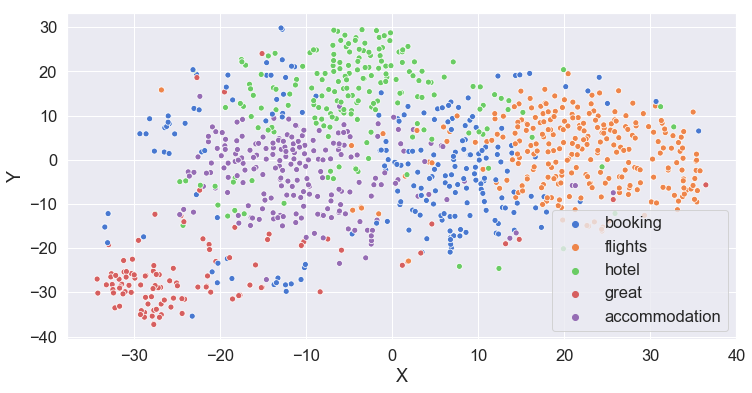

In [139]:
# plot topics
plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Y', data=pd.DataFrame(t_sne, columns=['X', 'Y']), 
                hue=pd.Series(document_clusters).map(cluster_lookup.to_dict()[0]))

### ToDos
3. assign a tag to a comment
4. calculate embedding for tag
5. compare results
6. assign tags based on similarities to other comments
7. emulate the app behavior